In [11]:
import sys, os
print(sys.executable)
print(os.getcwd())

C:\Users\chenr\miniforge3\envs\astropy\python.exe
C:\Users\chenr\OneDrive\Desktop\phys-134-proj


In [16]:
rootfolder=os.getcwd().replace('\\','/')
print(rootfolder)

C:/Users/chenr/OneDrive/Desktop/phys-134-proj/lco_data-20251202-36


In [13]:
os.chdir(f"{rootfolder}/lco_data-20251202-36")
os.getcwd()

'C:\\Users\\chenr\\OneDrive\\Desktop\\phys-134-proj\\lco_data-20251202-36'

In [6]:
import pickle 
with open('region_data.pkl', 'rb') as f:
    region_data = pickle.load(f)

In [17]:
#get array of files in directory
file_list=os.listdir(".")

# filter to only .fits files
file_list=[f for f in file_list if f.endswith('.fits') and f.startswith('2025')]
print(file_list)

['2025-11-25-h02-m00-s14-ms936-tfn.fits', '2025-11-25-h05-m00-s13-ms688-lsc.fits', '2025-11-25-h05-m36-s42-ms454-lsc.fits', '2025-11-25-h06-m06-s14-ms909-lsc.fits', '2025-11-25-h07-m45-s12-ms840-elp.fits', '2025-11-25-h08-m30-s09-ms718-elp.fits', '2025-11-25-h09-m06-s12-ms841-elp.fits', '2025-11-25-h10-m06-s14-ms367-elp.fits', '2025-11-25-h11-m06-s18-ms072-elp.fits', '2025-11-25-h12-m47-s39-ms526-ogg.fits', '2025-11-25-h13-m06-s13-ms287-ogg.fits', '2025-11-25-h14-m06-s15-ms196-ogg.fits', '2025-11-25-h23-m02-s40-ms929-tfn.fits', '2025-11-25-h23-m35-s17-ms210-cpt.fits', '2025-11-26-h00-m55-s17-ms907-tfn.fits', '2025-11-26-h01-m55-s17-ms940-tfn.fits', '2025-11-26-h02-m10-s07-ms425-tfn.fits', '2025-11-26-h03-m06-s19-ms581-tfn.fits', '2025-11-26-h04-m06-s16-ms133-tfn.fits', '2025-11-26-h05-m35-s14-ms393-lsc.fits', '2025-11-26-h06-m06-s06-ms084-lsc.fits', '2025-11-26-h07-m59-s44-ms591-elp.fits', '2025-11-26-h08-m06-s06-ms512-elp.fits', '2025-11-26-h11-m06-s14-ms445-ogg.fits', '2025-11-26-h12

In [220]:
#test
first =  region_data[list(region_data.keys())[0]]
name = list(region_data.keys())[0]
print(name)
x_cen_unrounded= first['x'][0]
y_cen_unrounded= first['y'][0]
x_cen= round(first['x'][0])
y_cen= round(first['y'][0])
print(x_cen,y_cen)

2025-11-25-h02-m00-s14-ms936-tfn.fits
1041 116


In [117]:
#pull the array from SCI of first file "name"
from astropy.io import fits
import numpy as np
hdul = fits.open(name)
sci_data = hdul['SCI'].data
print(type(sci_data),sci_data.shape)

<class 'numpy.ndarray'> (2400, 2400)


In [118]:
def imageprocessing(arr, min_clip=-100, max_clip=8000, a=1000, contrast=3.86, bias=0.442):
    clipped = np.clip(arr, min_clip, max_clip)
    norm = (clipped - min_clip) / (max_clip - min_clip)
    log = np.log(1 + a*norm) / np.log(a)
    final_data = (log- 0.5) * contrast + bias
    final_data = np.clip(final_data, 0, 1)
    return final_data

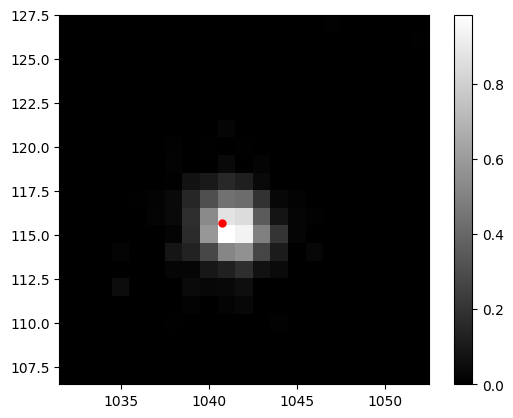

In [235]:

center= 10

ystart, yend = y_cen - center, y_cen + center + 1
xstart, xend = x_cen - center, x_cen + center + 1

smol_data = sci_data[ystart:yend, xstart:xend]

import matplotlib.pyplot as plt
#draw dot on center
# FITS convention: pixel [0,0] is at bottom-left corner, centered at (1,1) with left and bottom at 0.5
extent = [xstart + 0.5, xend + 0.5, ystart + 0.5, yend + 0.5]

plt.plot(x_cen_unrounded, y_cen_unrounded, 'ro', markersize=5)

plt.imshow(imageprocessing(smol_data), cmap='gray', origin='lower', extent=extent)
plt.colorbar()



# Extract 2D Gaussian Fit (Cumulative PSF) Parameters

In [236]:
aoi=smol_data
# offset is the center of the image
# run a 2d symmetric gaussian fit on aoi
from scipy.optimize import curve_fit
def gaussian_2d(xy, amp, xo, yo, sigma, offset):
    x, y = xy
    g = offset + amp * np.exp(-(((x - xo) ** 2 + (y - yo) ** 2) / (2 * sigma ** 2)))
    return g.ravel()


x = np.linspace(0, aoi.shape[1] - 1, aoi.shape[1])
y = np.linspace(0, aoi.shape[0] - 1, aoi.shape[0])
x, y = np.meshgrid(x, y)
initial_guess = (aoi.max(), center, center, 3, aoi.min())
popt, pcov = curve_fit(gaussian_2d, (x, y), aoi.ravel(), p0=initial_guess)
print(f"Fitted parameters: Amplitude={popt[0]}, X0={popt[1]}, Y0={popt[2]}, Sigma={popt[3]}, Offset(background noise level)={popt[4]}")



Fitted parameters: Amplitude=621.3478313225465, X0=9.402872270923641, Y0=8.357931361820048, Sigma=1.0009487055541948, Offset(background noise level)=3.391194294503062


PARAMETERS ARE CALCULATED ON NORMAL MACHINE COORDINATES where the first pixel is regarded as 0,0
So the fitted values, on representation, need to be adjusted

## Only Visualization

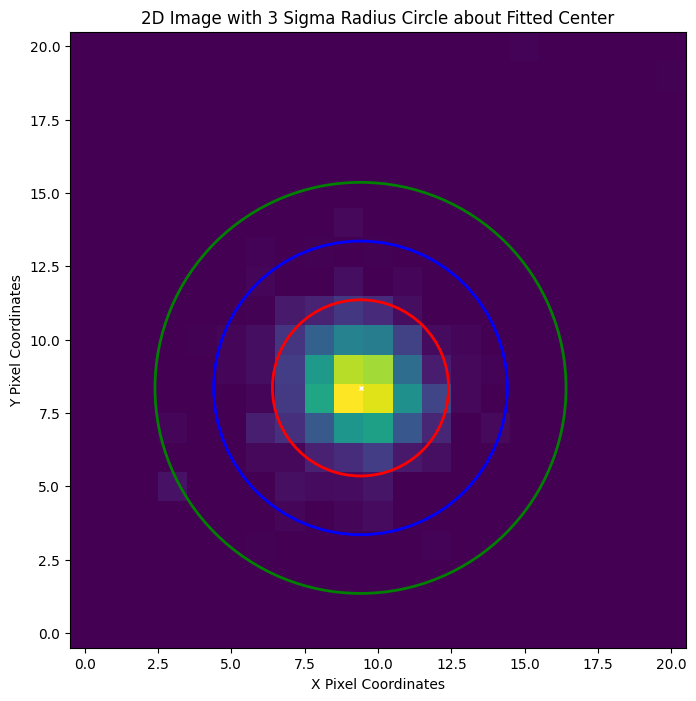

In [237]:
# plot the 2d image with 3 sigma radius circle about fitted center
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(imageprocessing(aoi), cmap='viridis', origin='lower')

# 3 sigma, 5 sigma, 7 sigma circles
sigma_fit = popt[3]
xo_fit = popt[1]
yo_fit = popt[2]
circle_3sigma = patches.Circle((xo_fit, yo_fit), 3*sigma_fit, edgecolor='red', facecolor='none', lw=2, label='3 Sigma')
ax.add_patch(circle_3sigma)
circle_5sigma = patches.Circle((xo_fit, yo_fit), 5*sigma_fit, edgecolor='blue', facecolor='none', lw=2, label='5 Sigma')
ax.add_patch(circle_5sigma)
circle_7sigma = patches.Circle((xo_fit, yo_fit), 7*sigma_fit, edgecolor='green', facecolor='none', lw=2, label='7 Sigma')
ax.add_patch(circle_7sigma)

#draw center point
ax.plot(xo_fit, yo_fit, 'wx', markersize=3, label='Fitted Center')

ax.set_title('2D Image with 3 Sigma Radius Circle about Fitted Center')
ax.set_xlabel('X Pixel Coordinates')
ax.set_ylabel('Y Pixel Coordinates')

plt.show()

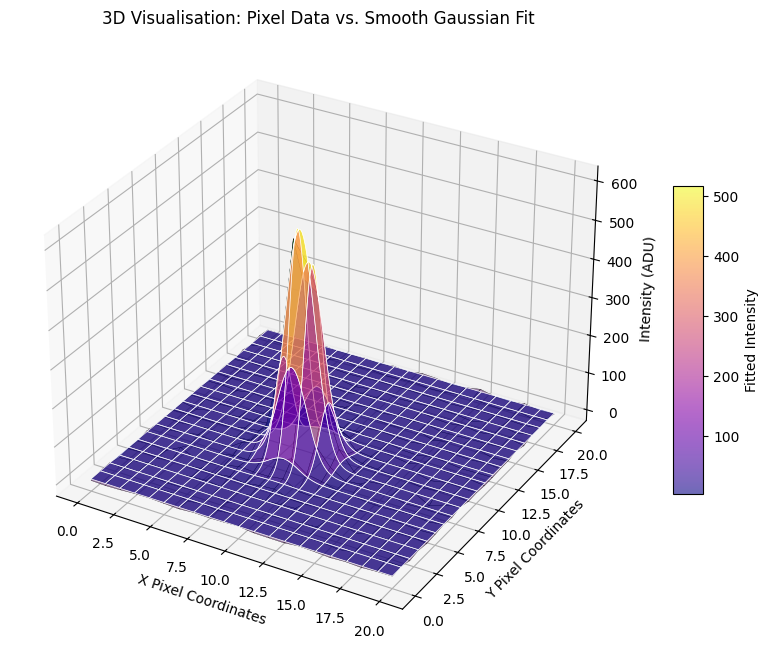

In [198]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X_pix, Y_pix = np.meshgrid(np.arange(aoi.shape[1]), np.arange(aoi.shape[0]))

# --- Part A: Plot the "Blocky" Sensor Data ---
# We plot the actual pixel values as a rough surface.
# We use a colormap (viridis) that maps low values to purple and high to yellow.
# alpha=0.5 makes it semi-transparent so we can see the fit through it/over it.
data_surf = ax.plot_surface(X_pix, Y_pix, aoi, cmap='viridis', 
                            linewidth=0.2, edgecolors='k', alpha=0.5, label='Pixel Data')


# --- Part B: Generate and Plot the Smooth Gaussian Mesh ---

# 1. Create a dense grid for smoothness. 
# Instead of N points, we use e.g., 200 points over the same spatial extent.
smoothness_factor = 200 
x_smooth = np.linspace(0, aoi.shape[1] - 1, smoothness_factor)
y_smooth = np.linspace(0, aoi.shape[0] - 1, smoothness_factor)
X_smooth, Y_smooth = np.meshgrid(x_smooth, y_smooth)

# 2. Calculate the fitted Gaussian heights on this new dense grid.
# Important: popt contains the 5 parameters found by curve_fit. Let's unpack them for clarity.
amp_fit, xo_fit, yo_fit, sigma_fit, offset_fit = popt

# We calculate the 2D gaussian using the smooth coordinates and fitted parameters.
# Note: We don't use the .ravel() version of the function here, we want the 2D shape.
Z_smooth = offset_fit + amp_fit * np.exp(-(((X_smooth - xo_fit)**2 + (Y_smooth - yo_fit)**2) / (2 * sigma_fit**2)))

# 3. Plot the smooth surface.
# We use a different colormap (plasma) to distinguish it visually.
# rstride and cstride control the density of the wireframe lines drawn on top of the surface.
fit_surf = ax.plot_surface(X_smooth, Y_smooth, Z_smooth, cmap='plasma', 
                           alpha=0.6, rstride=10, cstride=10, 
                           linewidth=0.5, edgecolors='w', shade=True)

# --- Part C: Aesthetics ---
ax.set_xlabel('X Pixel Coordinates')
ax.set_ylabel('Y Pixel Coordinates')
ax.set_zlabel('Intensity (ADU)')
ax.set_title('3D Visualisation: Pixel Data vs. Smooth Gaussian Fit')

# Add a colorbar to give context to heights
fig.colorbar(fit_surf, ax=ax, shrink=0.5, aspect=10, label='Fitted Intensity')

# Adjust the viewing angle for a better perspective
ax.view_init(elev=30, azim=-60)

plt.show()

# Aperture Photometry

In [203]:
def aperE(im, col, row, rad1, rad2, ir1, ir2, or1, or2, Kccd, saturation=np.inf):
    """Original code by Professor Alberto Bolatto, edited by Alyssa Pagan, and
    translated to Python by ChongChong He, further edited by Orion Guiffreda.

    Before using aperE.m, rotate your image using imrotate(im,angle) so the
    major axis of your object is perpendicular or parallel to your x or y axis.

    APER(im,col,row,rad1,rad1,ir1,ir2,or1,or2,Kccd) Do aperture photometry of 
    
    image "im"
    for a star, galaxy or nebula centered at the "row,col" coordinates, 
    For an ellipse with a major and minor axis of "rad1,rad2" 
    and an inner sky ellipse with a major and minor axis of (ir1,ir2)
    and outer sky ellipse of "or1,or2" 
    with CCD gain of Kccd ADU/electron. 
    Optionally, a 11th parameter can be passed with the saturation value for the CCD.
    """

    a, b = im.shape
    xx, yy = np.meshgrid(range(b), range(a))
    ixsrc = ((xx - col) / rad1) ** 2 + ((yy - row) / rad2) ** 2 <= 1
    ixsky = np.logical_and(
        (((xx - col) / or1) ** 2) + (((yy - row) / or2) ** 2) <= 1,
        (((xx - col) / ir1) ** 2) + (((yy - row) / ir2) ** 2) >= 1
    )
    length = max(ixsky.shape)
    sky = np.median(im[ixsky], axis=0)
    imixsrc = im[ixsrc]
    pix = imixsrc - sky
    sig = np.sqrt(imixsrc / Kccd)
    ssig = np.std(im[ixsky]) / np.sqrt(length) / Kccd
    flx = np.sum(pix)
    err = np.sqrt(np.sum(sig) ** 2 + ssig ** 2)
    issat = 0
    if max(imixsrc) > saturation:
        issat = 1
    fw = np.copy(or1)
    ix = np.where(
        np.logical_and(
            np.logical_and(
                np.logical_and(xx >= col - 2 * fw, xx <= col + 2 * fw),
                yy >= row - 2 * fw
            ),
            yy <= row + 2 * fw
        )
    )
    aa = np.sum(np.logical_and(xx[0, :] >= col - 2 * fw,
                               xx[0, :] <= col + 2 * fw))
    bb = np.sum(np.logical_and(yy[:, 0] >= row - 2 * fw,
                               yy[:, 0] <= row + 2 * fw))
    px = np.reshape(xx[ix], (bb, aa))
    py = np.reshape(yy[ix], (bb, aa))
    pz = np.reshape(im[ix], (bb, aa))
    plt.figure(figsize=(15,10))
    # plt.imshow(pz, extent=[px[0, 0], px[0, -1], py[0, 0], py[-1, 0]], vmin=0,vmax=250*25)
    pz_mod = imageprocessing(pz)
    
    plt.imshow(pz_mod, extent=[px[0, 0], px[0, -1], py[0, 0], py[-1, 0]])
    # plt.imshow(pz_mod, extent=[px[0, 0]-0.5, px[0, -1]+0.5
    #                           ,py[0, 0]-0.5, py[-1, 0]+0.5])
    
    
    plt.tight_layout()
    # if not np.isempty(imixsrc):
    #     np.caxis(np.concatenate((sky, np.array([max(imixsrc)]))))

    p = np.arange(360) * np.pi / 180
    xc = np.cos(p)
    yc = np.sin(p)
    plt.plot(col+rad1*xc, row+rad2*yc, 'w')
    plt.plot(col+ir1*xc, row+ir2*yc, 'r')
    plt.plot(col+or1*xc, row+or2*yc, 'r')
    # draw point at center
    plt.plot(col, row, 'wx')
    if issat:
        plt.text(col, row, 'CHECK SATURATION', ha='center', color='w',
                 va='top', fontweight='bold')
        print('At the peak this source has {:0.0f} counts.'.format(
            max(imixsrc)))
        print('Judging by the number of counts, if this is a single exposure the')
        print('source is likely to be saturated. If this is the coadding of many')
        print('short exposures, check in one of them to see if this message appears.')
        print('If it does, you need to flag the source as bad in this output file.')
    plt.tight_layout()
    plt.savefig("aperE_img.pdf")
    plt.gca().invert_yaxis()
    return flx, err, sky


kccd = 1 # inverse ratio: 1 ADU / N electron

(np.float32(3816.8142), np.float64(289.62584389285803), np.float32(3.7279747))

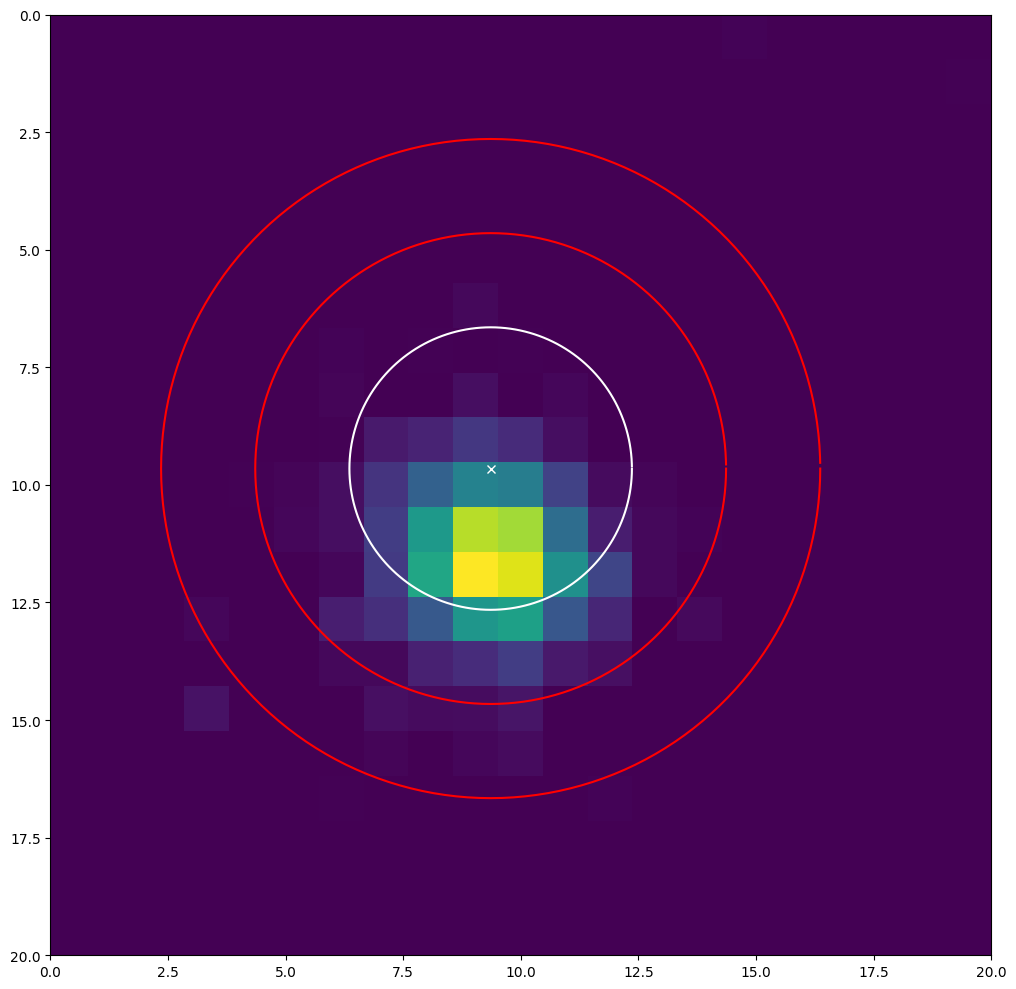

In [204]:
aperE(aoi, yo_fit+1, xo_fit+0.25, 3*sigma_fit, 3*sigma_fit, 5*sigma_fit, 5*sigma_fit, 7*sigma_fit, 7*sigma_fit, kccd)

In [ ]:
# astroart photoutils
from astroart.photoutils import aperture_photometry, CircularAperture, CircularAnnulus
